# 🏗️ AI Safety Guard - Data Engineering Setup
**Project:** PPE Detection (Helmets and Vests) on Construction Sites.

In this notebook, we perform the ingestion and preparation of data to train a **YOLOv8** model on Amazon SageMaker.

### Objectives:
1. **Extraction:** Unzip the raw dataset (YOLOv8 PyTorch format).
2. **Validation:** Visualize images and *bounding boxes* to ensure data integrity.
3. **Upload:** Upload the correct folder structure to Amazon S3.

## Imports and settings


In [ ]:
import sagemaker
import boto3
import os
import urllib.request
import zipfile
import yaml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

boto_session = boto3.Session(profile_name='pessoal', region_name='us-east-1')
bucket_name = 'sagemaker-portfolio-cv-aws' 
sess = sagemaker.Session(boto_session=boto_session, default_bucket=bucket_name)
region = sess.boto_region_name

print(f"Region: {region}")
print(f"Target bucket: {bucket_name}")

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\josel\AppData\Local\sagemaker\sagemaker\config.yaml
Região: us-east-1
Bucket alvo: sagemaker-portfolio-cv-aws


In [ ]:
from utils.bucket import create_bucket_if_not_exists

s3_client = boto_session.client('s3', region_name=region)
create_bucket_if_not_exists(s3_client, bucket_name, region)

In [2]:
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if BASE_DIR not in sys.path:
    sys.path.append(BASE_DIR)

## Local Data Extraction
The dataset was downloaded from Roboflow [available here](https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety) and is located at `../../data/raw/ppe_data.zip`. We will extract it while maintaining the standard YOLO directory structure.

In [3]:
local_zip_path = '../../data/raw/ppe_data.zip'
extract_path = '../../data/raw/ppe'

In [ ]:
if not os.path.exists(extract_path):
    print(f"Extracting {local_zip_path}...")
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed.")
else:
    print("File already extracted. Skipping extraction.")

In [4]:
print(f"\nConteúdo da raiz ({extract_path}):")
print(os.listdir(extract_path))


Conteúdo da raiz (../../data/raw/ppe):
['data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']


## Sanity check

Let's plot some data to check if all ok

In [5]:
def plot_sample(image_path, label_path, class_names):
    im = Image.open(image_path)
    w, h = im.size
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(im)
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            
            cx, cy, bw, bh = map(float, parts[1:])
            
            box_w = bw * w
            box_h = bh * h
            box_x = (cx * w) - (box_w / 2)
            box_y = (cy * h) - (box_h / 2)
            
            rect = patches.Rectangle(
                (box_x, box_y), box_w, box_h, 
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            
            if class_names and class_id < len(class_names):
                label_name = class_names[class_id]
                plt.text(box_x, box_y - 5, label_name, color='white', 
                         bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

Classes encontradas: ['Excavator', 'Gloves', 'Hardhat', 'Ladder', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'SUV', 'Safety Cone', 'Safety Vest', 'bus', 'dump truck', 'fire hydrant', 'machinery', 'mini-van', 'sedan', 'semi', 'trailer', 'truck', 'truck and trailer', 'van', 'vehicle', 'wheel loader']
Visualizando: -1670-_png_jpg.rf.401e319f51f626c5e05ec0692c49b6c4.jpg


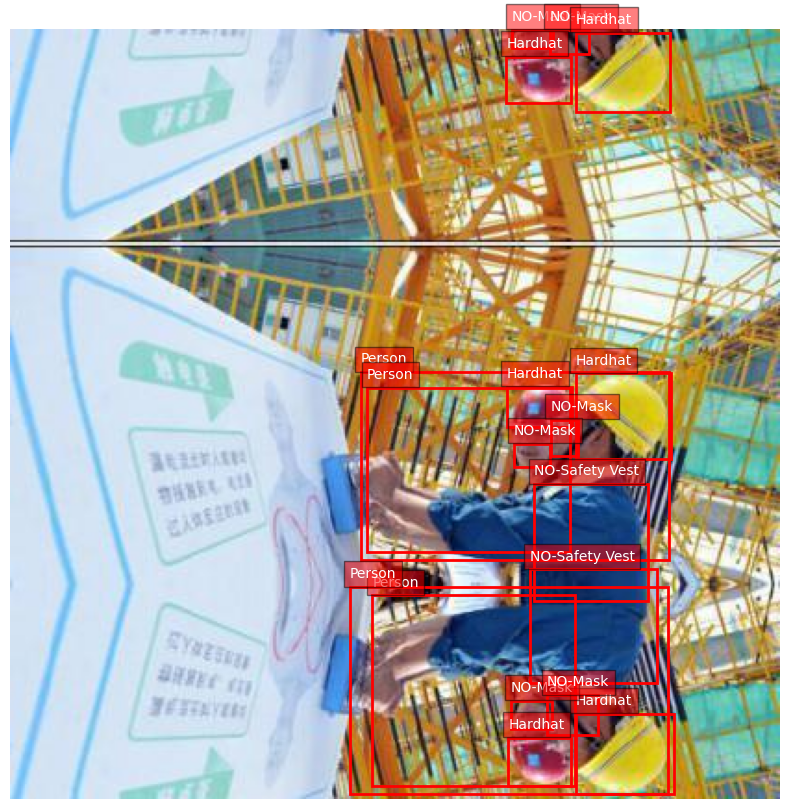

In [ ]:

yaml_path = os.path.join(extract_path, 'data.yaml')
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)
    class_names = data_config.get('names', [])

print(f"Labels: {class_names}")

train_img_dir = os.path.join(extract_path, 'train', 'images')
train_lbl_dir = os.path.join(extract_path, 'train', 'labels')
sample_img = os.listdir(train_img_dir)[0]
sample_lbl = sample_img.replace('.jpg', '.txt').replace('.png', '.txt')

print(f"Visualizing: {sample_img}")
plot_sample(
    os.path.join(train_img_dir, sample_img), 
    os.path.join(train_lbl_dir, sample_lbl), 
    class_names
)

## Upload the data to s3 bucket

In [6]:
import importlib
import utils.bucket
importlib.reload(utils.bucket)

<module 'utils.bucket' from 'f:\\Pessoal\\aws-sagemaker-cv-pipeline\\notebooks\\utils\\bucket.py'>

In [9]:
from utils.bucket import upload_to_s3


prefix = "data/raw/ppe"

local_dataset_path = extract_path

s3_data_uri = upload_to_s3(sess, local_dataset_path, bucket_name, prefix)

print(f"Data loaded to: {s3_data_uri}. IMPORTANT: Check if the data was correctly uploaded to the S3 bucket.")
print("Upload completed.")

Iniciando upload de '../../data/raw/ppe' para 's3://sagemaker-portfolio-cv-aws/data/raw/ppe'
  Upload: data/raw/ppe/test/images/Inside-merge_mov-58_jpg.rf.d04f7eb88be9e76af0186ea28f0a2dcb.jpg
  Upload: data/raw/ppe/test/labels/777_jpg.rf.27d751af375f635def7523cd8b2c880d.txt
  Upload: data/raw/ppe/test/labels/youtube-213_jpg.rf.548e532a2220acfdbfd91421ebb2e9cf.txt
  Upload: data/raw/ppe/train/images/02629_jpg.rf.664b948ee635abc91ffdbf1fe3b2cd92.jpg
  Upload: data/raw/ppe/train/images/amz_02354_png_jpg.rf.93ee089350f9f2eeac3d2aa9dd07121f.jpg
  Upload: data/raw/ppe/train/images/construction-246-_jpg.rf.b56eb2666fa9fe8d4378d68f0f6ee446.jpg
  Upload: data/raw/ppe/train/images/construction-572-_jpg.rf.c9c0fb0946fe292c29de0673d2293507.jpg
  Upload: data/raw/ppe/train/images/image_257_jpg.rf.402c03ba3f14e089da673ec3d80a55ab.jpg
  Upload: data/raw/ppe/train/images/image_880_jpg.rf.c6e640843d763ae147c3f8372fb20e02.jpg
  Upload: data/raw/ppe/train/images/IMG_7211_PNG_jpg.rf.4843bb35518c92aa82e7b7